In [40]:
%pylab inline
from glob import glob
import pysam
from collections import namedtuple
import re
import pandas

bams = glob('../samples/*.bam')
sample_names = [re.search('([CHP]_[0-9]{4})',_).group(1) for _ in bams]
bams = pandas.Series(bams,index=sample_names)

ensid = 'ENSG00000272403'
Region = namedtuple('Region',['chrm','st','en'])
region = Region('chr6',116444160,116444860)

Populating the interactive namespace from numpy and matplotlib


In [41]:
import numpy as np
# this function implements the deseq2 normalization procedure
def estimateSizeFactors(cnts) :

  loggeomeans = np.log(cnts).mean(axis=1)
  if all(~np.isfinite(loggeomeans)) :
    raise NormalizationException(
     'every gene contains at least one zero, cannot compute log geometric means'
    )

  divFact = (np.log(cnts).T - loggeomeans).T
  sizeFactors = np.exp(
    np.apply_along_axis(
      lambda c: np.median(c[np.isfinite(c)])
      ,0
      ,divFact
    )
  )

  return sizeFactors
cnts = pandas.read_csv('../all_mRNA_nonzero_raw_counts_trim.csv',index_col=0)
size_factors = estimateSizeFactors(cnts)
size_factors = pandas.Series(size_factors,index=cnts.columns)

/home/labadorf/anaconda3/envs/hdvpd_mrnaseq/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/home/labadorf/anaconda3/envs/hdvpd_mrnaseq/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


In [42]:
window_up, window_down = 8000,500

counts = []
pileup = pandas.DataFrame(
    index=list(range(region.st-window_up,region.en+window_down+1))
    ,columns=sample_names
)
pileup.fillna(0,inplace=True)

for sample_name, bam in bams.iteritems() :
    samfile = pysam.AlignmentFile(bam,'rb')
    for i, read in enumerate(samfile.fetch(region.chrm,region.st-window_up,region.en+window_down)) :
        for j,k in read.aligned_pairs :
            if k in pileup.index :
                pileup.loc[k,sample_name] += 1
    counts.append(i+1)
counts = pandas.Series(counts,index=sample_names)
counts = counts[counts.index.sort_values()]

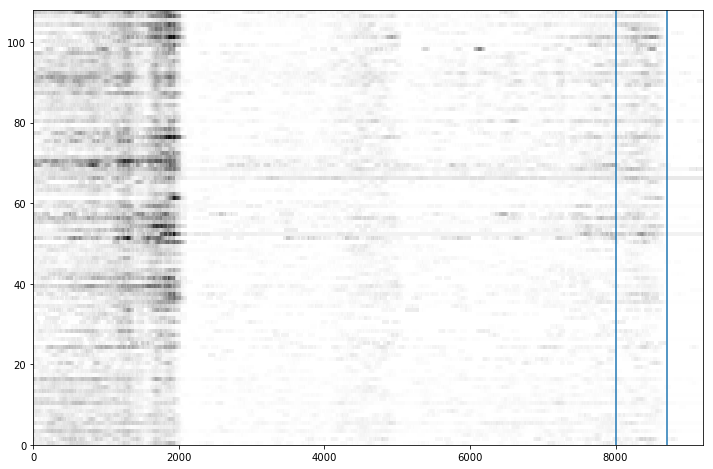

In [50]:
pileup = pileup[counts.index.sort_values()]
norm_pileup = pileup.div(size_factors[pileup.columns],axis=1)
figure(figsize=(12,8))
pcolormesh(norm_pileup.T,cmap=cm.binary)
#yticks(arange(len(sample_names))+.5,pileup.columns,fontsize=8)
axvline(window_up)
axvline(norm_pileup.shape[0]-window_down)
savefig('ENSG00000272403_expression.png',dpi=300)

In [54]:
arange(region.st-window_up,region.en + window_down, (region.en+window_down - (region.st-window_up))/4)

array([  1.16436160e+08,   1.16438460e+08,   1.16440760e+08,
         1.16443060e+08])

In [45]:
df.loc[1,'a'] = 3
df
for k,v in bams.items() : print(k,v)

NameError: name 'df' is not defined